In [1]:
# we load 6 models from different frameworks and compare their outputs on the same input
# qwen4, qwen4-instruct, qwen4-reasoing, qwen4-vl, qwen4-embedding, qwen4-reranking

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
import torch

model_names = {
    "Base" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-4B"},
    "Instruct" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-4B-Instruct-2507"},
    "Thinking" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-4B-Thinking-2507"},
    # "Audio" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-4B-Audio-2507"},
    # "Picture" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-4B-Picture-2507"},
    "Embedding" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-Embedding-4B"},
    "Reranker" : {'path':"/u/anp407/Workspace/Huggingface/Qwen/Qwen3-Reranker-4B"}
}
device_name = "cuda:3"

/u/anp407/.cache/conda_envs/unknownattack/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
for names in model_names:
    model = AutoModelForCausalLM.from_pretrained(model_names[names]['path'], dtype=torch.float16, device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(model_names[names]['path'], use_fast=False)
    model.eval()
    model_names[names]['model'] = model
    model_names[names]['tokenizer'] = tokenizer
    

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


In [4]:
sample_sentence = "New York is an important place for the American entertainment industry, with many movies, television series, books, and other media being set there. , New York City was the second biggest center for filmmaking and television production in the United States, making about 200 feature films every year, making about 130,000 jobs. The filmed entertainment industry has been growing in New York, providing nearly $9 billion to the New York City economy as of 2015. By amount, New York is the world leader in independent film production—one-third of all American independent films are created there. The Association of Independent Commercial Producers is also based in New York."

for names in model_names: 
    # get the tokenizer, first embedding, all layer embedding
    sample_ids = model_names[names]['tokenizer'](sample_sentence, return_tensors="pt").input_ids.cuda()
    # save the sample_ids
    model_names[names]["sample_ids"] = sample_ids
    
    with torch.no_grad():
        outputs = model_names[names]['model'](sample_ids, output_hidden_states=True)
        logits = outputs.logits
        all_embeddings = outputs.hidden_states
        
        first_embedding = outputs.hidden_states[0]
        last_embedding = outputs.hidden_states[-1]
        
        # can I get the embeddings before the normalization layer? Unsure99
        
        model_names[names]["first_embedding"] = first_embedding.detach().to('cpu')
        model_names[names]["last_embedding"] = last_embedding.detach().to('cpu')
        model_names[names]["logits"] = logits.detach().to('cpu')
        model_names[names]["all_embeddings"] = [x.detach().to('cpu') for x in all_embeddings]
        model_names[names]["mid_embedding"] = outputs.hidden_states[len(outputs.hidden_states)//2].detach().to('cpu')
        
        del first_embedding, last_embedding, all_embeddings, outputs

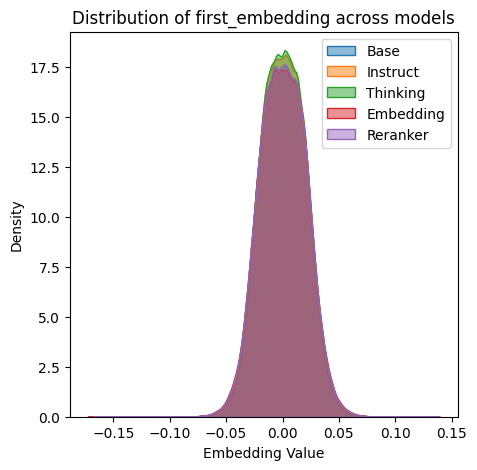

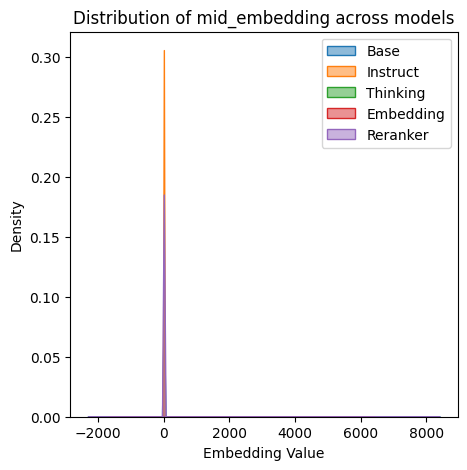

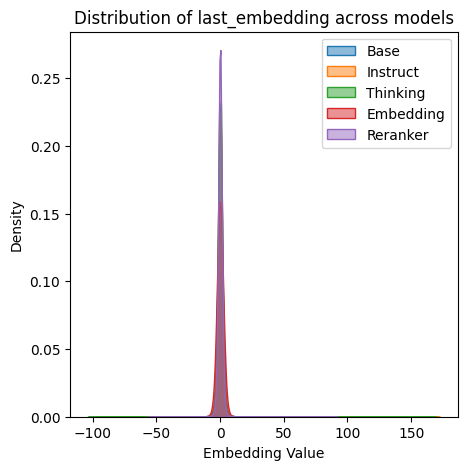

In [5]:
# first, plot the distribution of the first embedding, last embedding, and input embedding for each model in three figures
# my hypothesis is that these distribution looks similar and follow gaussian distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for embed_type in ["first_embedding", "mid_embedding","last_embedding"]:
    plt.figure(figsize=(5, 5))
    for names in model_names:
        embedding = model_names[names][embed_type].cpu().numpy().flatten()
        sns.kdeplot(embedding, label=names, fill=True, alpha=0.5, legend=True)
        
        # assume the embedding follows gaussian distribution, plot the gaussian distribution
        mu = torch.mean(model_names[names][embed_type]).item()
        sigma = torch.std(model_names[names][embed_type]).item()
    
    plt.title(f'Distribution of {embed_type} across models')
    plt.xlabel('Embedding Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [6]:
# check the number of layer in each model
for names in model_names:
    num_layers = len(model_names[names]['all_embeddings']) - 1  # excluding the input embedding
    print(f'Model: {names}, Number of layers: {num_layers}')

Model: Base, Number of layers: 36
Model: Instruct, Number of layers: 36
Model: Thinking, Number of layers: 36
Model: Embedding, Number of layers: 36
Model: Reranker, Number of layers: 36


In [7]:
# for each model, plot the KL divergence between the first embedding and last embedding
from scipy.stats import entropy

KV_divergences = {}
visited_pairs = set()
# m1_m2_ln
for names in model_names:
    # for the other models behind
    for other_names in model_names:
        if (names, other_names) in visited_pairs or (other_names, names) in visited_pairs:
            continue
        visited_pairs.add((names, other_names))
        if names != other_names: 
            for layer_num in range(len(model_names[names]['all_embeddings'])):
                m1 = model_names[names]['all_embeddings'][layer_num].cpu().numpy().flatten()
                m2 = model_names[other_names]['all_embeddings'][layer_num].cpu().numpy().flatten()
                
                # compute the histogram
                hist1, bin_edges = np.histogram(m1, bins=100, density=True)
                hist2, _ = np.histogram(m2, bins=bin_edges, density=True)
                
                # add a small value to avoid zero division
                hist1 += 1e-10
                hist2 += 1e-10
                # calculate kl * dim
                
                kl_div = entropy(hist1, hist2) * m1.shape[0]
                
                KV_divergences[f'{names}_{other_names}_layer{layer_num}'] = kl_div

In [8]:
print(min(KV_divergences.values()))
print(max(KV_divergences.values()))

# print where the min and max occur
for key, value in KV_divergences.items():
    if value == min(KV_divergences.values()):
        print(f'Min KL Divergence: {key}, Value: {value}')
    if value == max(KV_divergences.values()):
        print(f'Max KL Divergence: {key}, Value: {value}')

0.0
84426.22209515162
Min KL Divergence: Base_Reranker_layer0, Value: 0.0
Min KL Divergence: Base_Reranker_layer7, Value: 0.0
Min KL Divergence: Base_Reranker_layer8, Value: 0.0
Max KL Divergence: Embedding_Reranker_layer36, Value: 84426.22209515162


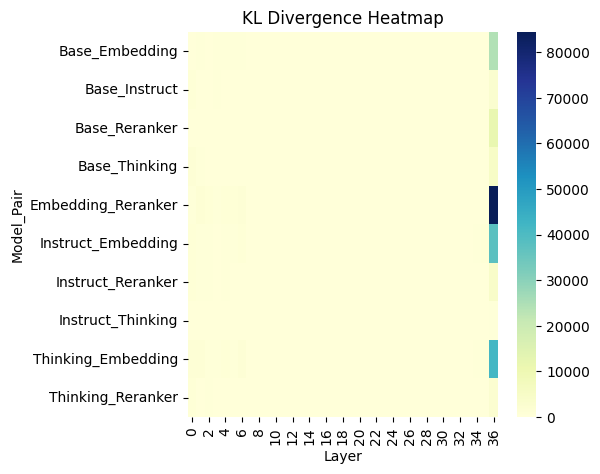

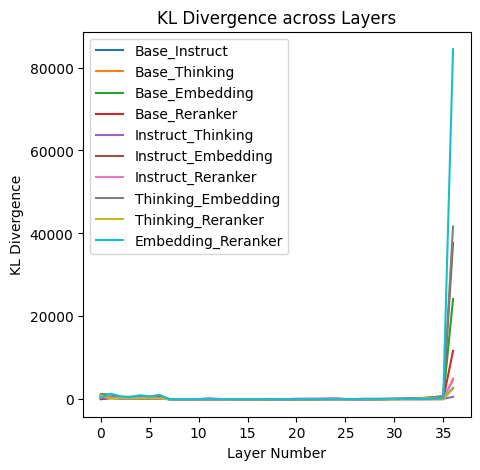

In [9]:
# plot the KL divergence heatmap, x axis is the layer number, y axis KL divergence
import pandas as pd
import seaborn as sns

kl_data = []
for key, value in KV_divergences.items():
    model_pair, layer_info = key.rsplit('_layer', 1)
    layer_num = int(layer_info)
    kl_data.append({'Model_Pair': model_pair, 'Layer': layer_num, 'KL_Divergence': value})

kl_df = pd.DataFrame(kl_data)
plt.figure(figsize=(5, 5))
# TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given
sns.heatmap(kl_df.pivot(index="Model_Pair", columns="Layer", values="KL_Divergence"), cmap="YlGnBu")
plt.title("KL Divergence Heatmap")
plt.show()

# plot 10 lines for each model pair, aggregate the pair, x is layer number, y is KL divergence
plt.figure(figsize=(5, 5))
for model_pair in kl_df['Model_Pair'].unique():
    subset = kl_df[kl_df['Model_Pair'] == model_pair]
    # plot in exponential scale
    plt.plot(subset['Layer'], subset['KL_Divergence'], label=model_pair)

plt.title("KL Divergence across Layers")
plt.xlabel("Layer Number")
plt.ylabel("KL Divergence")
plt.legend()
plt.show()

In [10]:
# question two, the add, replace and modification, how it affect model diffe
import random

mod_times = 10
mod_action = ['add','replace','delete']

sample_sentence = "New York is an important place for the American entertainment industry, with many movies, television series, books, and other media being set there. , New York City was the second biggest center for filmmaking and television production in the United States, making about 200 feature films every year, making about 130,000 jobs. The filmed entertainment industry has been growing in New York, providing nearly $9 billion to the New York City economy as of 2015. By amount, New York is the world leader in independent film production—one-third of all American independent films are created there. The Association of Independent Commercial Producers is also based in New York."

def get_random_token_in_all_models(model_names):
        while True:
            token_id = random.randint(0, model_names['Base']['tokenizer'].vocab_size-1)
            token = model_names['Base']['tokenizer'].convert_ids_to_tokens(token_id)
            # check if r_word in all models tokenizer
            exist_all = True
            for names in model_names:
                if token not in model_names[names]['tokenizer'].get_vocab():
                    exist_all = False
                    break
            if exist_all:
                break
        return token, token_id

a_sentence = sample_sentence
r_sentence = sample_sentence
d_sentence = sample_sentence

noise_result = {}
a_token_list = []
r_token_list = []
a_position_list = []
r_position_list = []
d_position_list = []

a_inputs = model_names[names]['tokenizer'](a_sentence, return_tensors="pt").input_ids
r_inputs = model_names[names]['tokenizer'](r_sentence, return_tensors="pt").input_ids
d_inputs = model_names[names]['tokenizer'](d_sentence, return_tensors="pt").input_ids

for m_times in range(mod_times):
    
    # get the add token and replace token
    a_token, a_token_id = get_random_token_in_all_models(model_names=model_names)
    r_token, r_token_id = get_random_token_in_all_models(model_names=model_names)
    # get the add, replace and delete position    
    
    a_position = random.randint(0, len(a_inputs[0]))
    r_position = random.randint(0, len(r_inputs[0]))
    d_position = random.randint(0, len(d_inputs[0])-1) if len(d_inputs[0])>0 else 0
    
    a_token_list.append(a_token)
    r_token_list.append(r_token)
    a_position_list.append(a_position)
    r_position_list.append(r_position)
    d_position_list.append(d_position)
    
    # update the a_inputs, r_inputs, d_inputs. Use torch.cat to concatenate tensors
    a_inputs = torch.cat([a_inputs[:, :a_position], torch.tensor([[a_token_id]], dtype=a_inputs.dtype, device=a_inputs.device), a_inputs[:, a_position:]], dim=1)
    r_inputs = torch.cat([r_inputs[:, :r_position], torch.tensor([[r_token_id]], dtype=r_inputs.dtype, device=r_inputs.device), r_inputs[:, r_position+1:]], dim=1)
    d_inputs = torch.cat([d_inputs[:, :d_position], d_inputs[:, d_position+1:]], dim=1)
                
    for names in model_names:
        # random position
        
        for m_action in mod_action:            
            # add a new token to the token inputs
            if m_action == 'add':
                # add a new token to the token inputs
                with torch.no_grad():
                    a_embedding = model_names[names]['model'](a_inputs.cuda(), output_hidden_states=True).hidden_states
                a_logits = model_names[names]['model'](a_inputs.cuda()).logits
                noise_result[f'{names}_add_{m_times}'] = {'all_embedding':[x.detach().to('cpu') for x in a_embedding], 'position_list':a_position_list, 'token_list':a_token_list, 'logits':a_logits.detach().to('cpu')}
                del a_embedding
                
            # replace a token in the token inputs
            elif m_action == 'replace':
                with torch.no_grad():
                    r_embedding = model_names[names]['model'](r_inputs.cuda(), output_hidden_states=True).hidden_states
                r_logits = model_names[names]['model'](r_inputs.cuda()).logits
                noise_result[f'{names}_replace_{m_times}'] = {'all_embedding':[x.detach().to('cpu') for x in r_embedding], 'position_list':r_position_list, 'token_list':r_token_list, 'logits':r_logits.detach().to('cpu')}
                del r_embedding
                
            # delete a token from the token inputs
            elif m_action == 'delete':
                # get the embeddings 
                d_sample_ids = d_inputs.cuda()
                with torch.no_grad():
                    d_embedding = model_names[names]['model'](d_inputs.cuda(), output_hidden_states=True).hidden_states
                d_logits = model_names[names]['model'](d_inputs.cuda()).logits
                noise_result[f'{names}_delete_{m_times}'] = {'all_embedding':[x.detach().to('cpu') for x in d_embedding], 'position_list':d_position_list, 'logits':d_logits.detach().to('cpu')}
                del d_embedding

In [11]:
for key in noise_result:
    # calculate the difference
    # split the name
    # get the original embedding
    names = key.split('_')[0]
    action = key.split('_')[1]
    m_times = int(key.split('_')[2])
    # calculate the difference 
    o_embedding = np.array(model_names[names]['all_embeddings'])
    m_embedding = np.array(noise_result[key]['all_embedding'])
    base_shape = o_embedding.shape[-1] * o_embedding.shape[-2]
    print(f'Processing {key}, original shape: {o_embedding.shape}, modified shape: {m_embedding.shape}')
    # let's do this
    for j in range(m_times+1):
        # if the action is add, replace, delete
        if action == 'add':
            # get the position list
            positions = noise_result[key]['position_list']
            pos = positions[j]
            # add empty vector to the position
            empty_vector = np.zeros((len(o_embedding),1, 1, o_embedding.shape[3]), dtype=o_embedding.dtype)
            o_embedding = np.concatenate([o_embedding[:, :, :pos, :], empty_vector, o_embedding[:, :, pos:, :]], axis=2)
        elif action == 'replace':
            # do nothing
            pass
        elif action == 'delete':
            # get the position list
            positions = noise_result[key]['position_list']
            pos = positions[len(positions)-j-1] # reverse order
            # add empty vector to the position
            empty_vector = np.zeros((len(m_embedding),1, 1, m_embedding.shape[3]), dtype=m_embedding.dtype)
            m_embedding = np.concatenate([m_embedding[:, :, :pos, :], empty_vector, m_embedding[:, :, pos:, :]], axis=2)
            
    # store the KL divergence, and L2 distance
    # compute the histogram
    kl_list = []
    l2_list = []
    for layer_num in range(len(o_embedding)):
        m1 = o_embedding[layer_num].flatten()
        m2 = m_embedding[layer_num].flatten()
        
        # calculate L2 distance
        l2_dist = np.linalg.norm(m1/100 - m2/100)
        l2_dist = l2_dist * 100
        l2_list.append(l2_dist)
        
        hist1, bin_edges = np.histogram(m1, bins=100, density=True)
        hist2, _ = np.histogram(m2, bins=bin_edges, density=True)
        
        # add a small value to avoid zero division
        hist1 += 1e-10
        hist2 += 1e-10
        # calculate kl * dim
        
        kl_div = entropy(hist1, hist2) * m1.shape[0] / base_shape
        # print('m1 shape:', m1.shape, 'm2 shape:', m2.shape, 'kl div:', kl_div)
        kl_list.append(kl_div)
    noise_result[key]['kl_list'] = kl_list
    noise_result[key]['l2_list'] = l2_list
    
     

Processing Base_add_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 142, 2560)
Processing Base_replace_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 141, 2560)
Processing Base_delete_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 140, 2560)
Processing Instruct_add_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 142, 2560)
Processing Instruct_replace_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 141, 2560)
Processing Instruct_delete_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 140, 2560)
Processing Thinking_add_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 142, 2560)
Processing Thinking_replace_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 141, 2560)
Processing Thinking_delete_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 140, 2560)
Processing Embedding_add_0, original shape: (37, 1, 141, 2560), modified shape: (37, 1, 142, 2560)
Processing

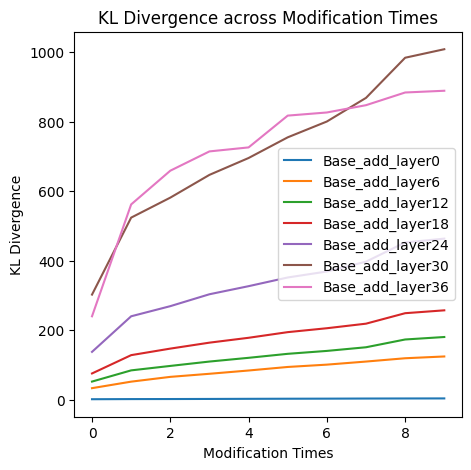

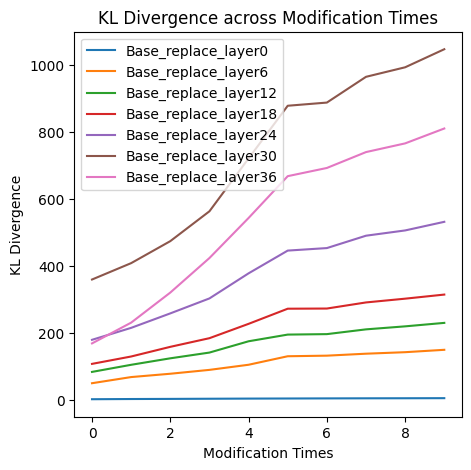

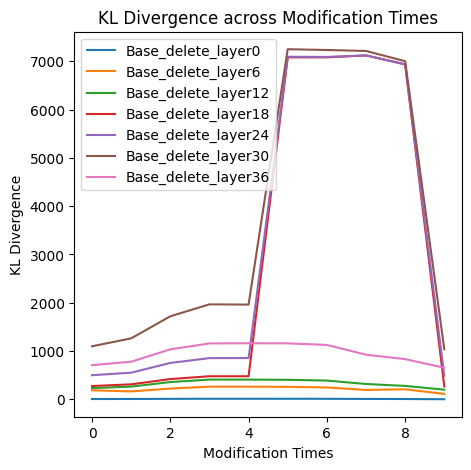

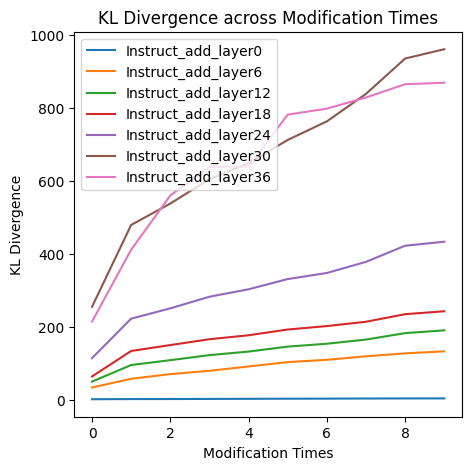

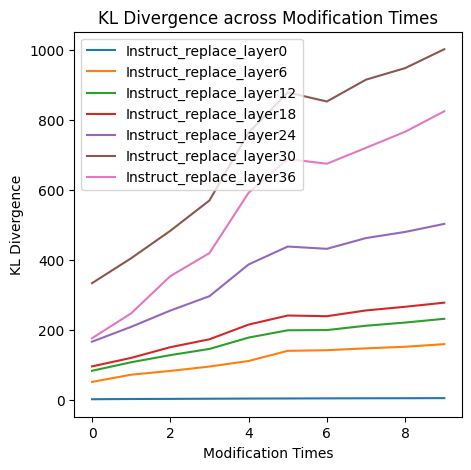

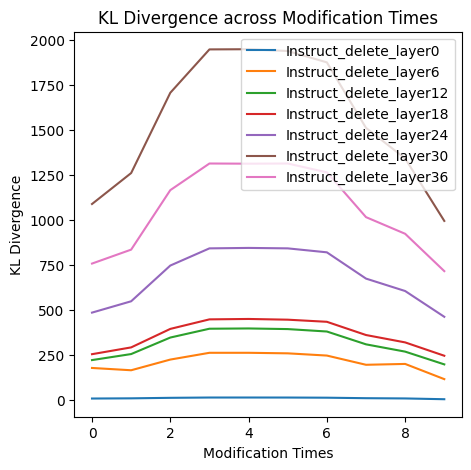

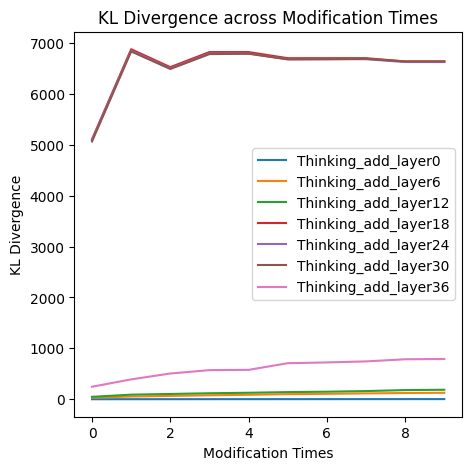

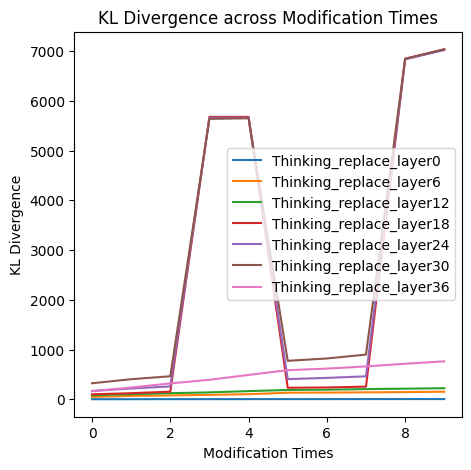

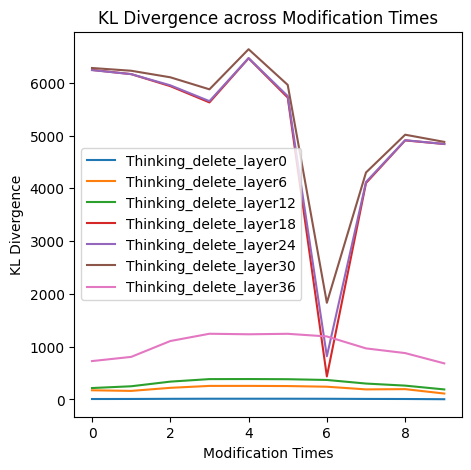

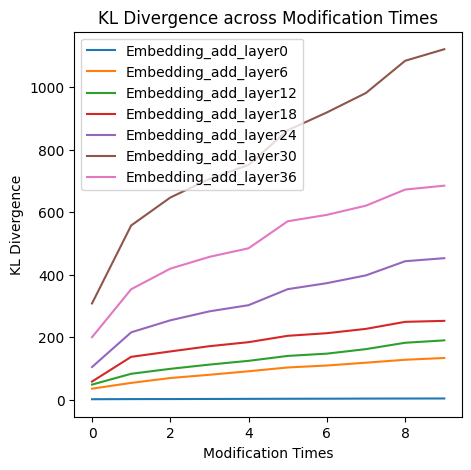

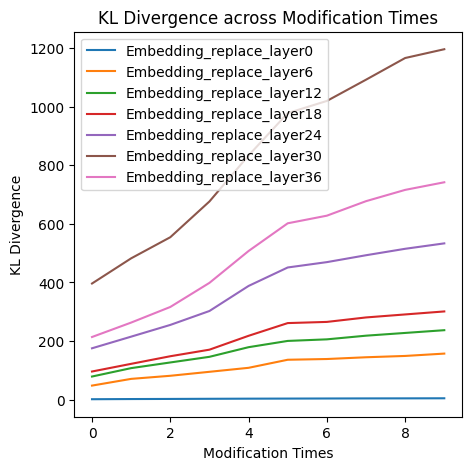

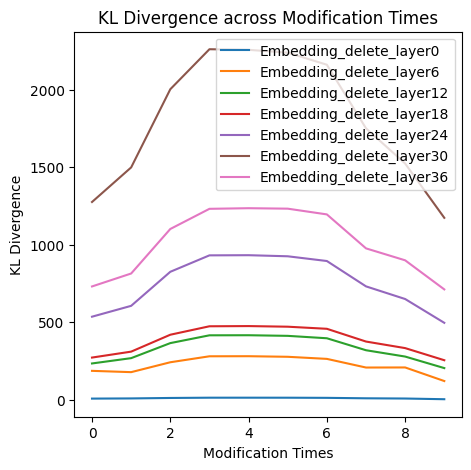

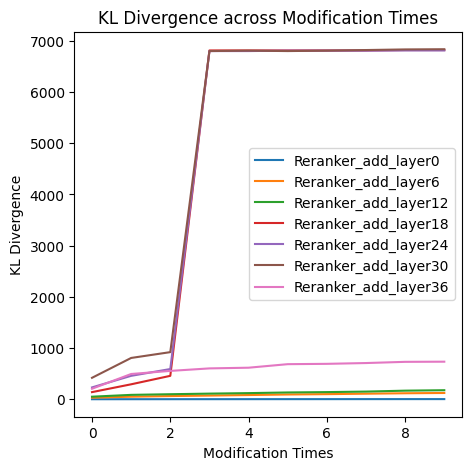

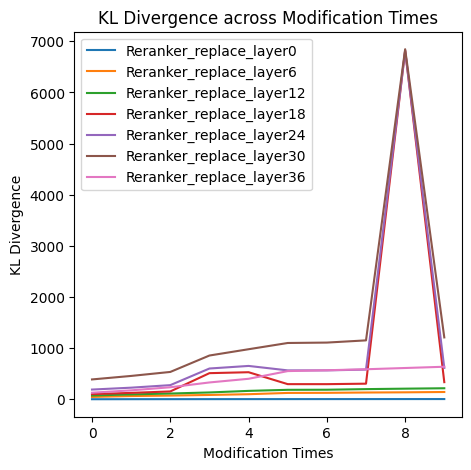

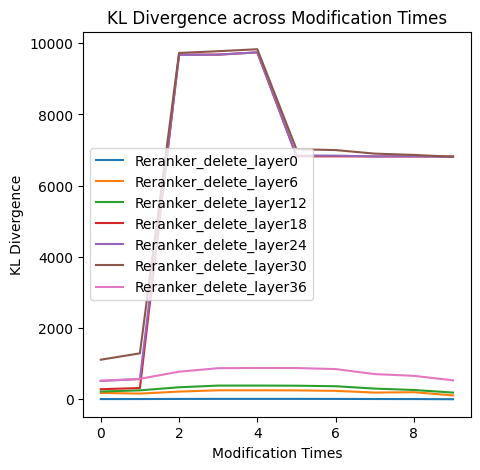

In [12]:
# plot 10 lines for each model pair, aggregate the pair, x is layer number, y is KL divergence
import pandas as pd
import seaborn as sns
# use layers [0, 17, 36] to plot
# figure 1. I want to see the change of KL divergence on times
# fixed model, fixed action, fixed layer, x is times, y is KL divergence
for names in model_names:
    for action in mod_action:
        plt.figure(figsize=(5, 5))
        for layer_num in range(len(model_names[names]['all_embeddings'])):
            kl_y = []
            times_x = []
            # use the selected 
            if layer_num not in [0, 6, 12, 18, 24, 30, 36]:
                continue
            for m_times in range(mod_times):
                key = f'{names}_{action}_{m_times}'
                kl_y.append(noise_result[key]['l2_list'][layer_num])
                times_x.append(m_times)
            plt.plot(times_x, kl_y, label=f'{names}_{action}_layer{layer_num}')
        plt.title("KL Divergence across Modification Times")
        plt.xlabel("Modification Times")
        plt.ylabel("KL Divergence")
        plt.legend()
plt.show()


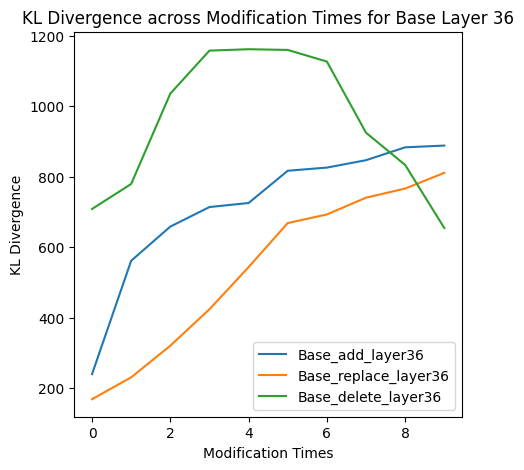

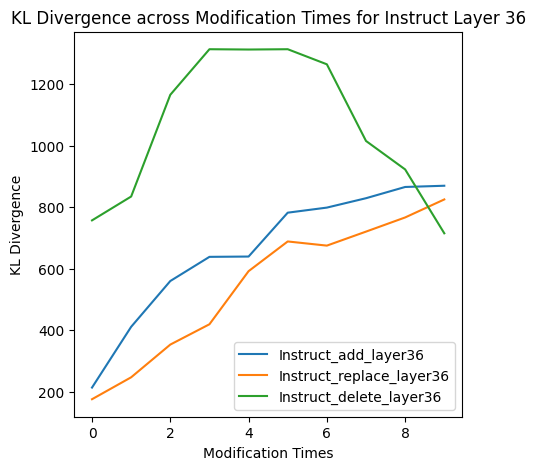

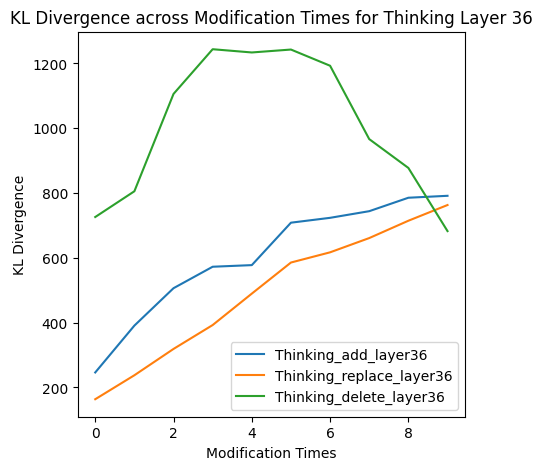

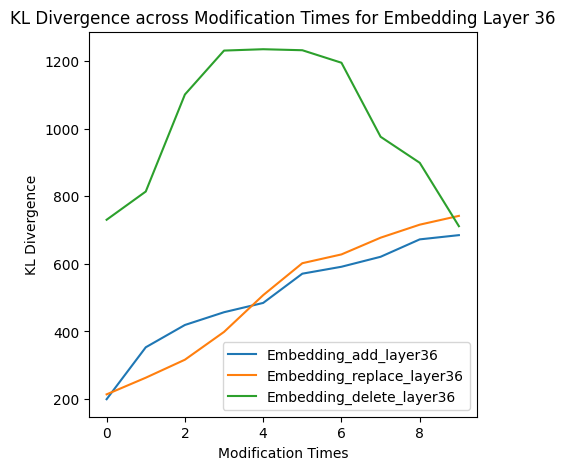

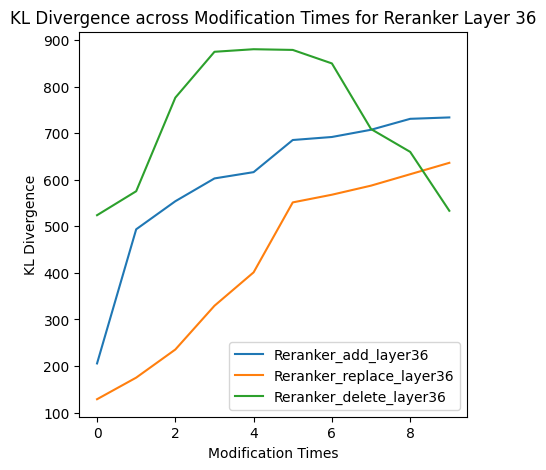

In [21]:
# plot the different action on the same model and layer
for layer_num in range(len(model_names[names]['all_embeddings'])):
    if layer_num not in [36]:
        continue
    
    for names in model_names:
        plt.figure(figsize=(5, 5))
        for action in mod_action:
            kl_y = []
            times_x = []
            # use the selected 
            for m_times in range(mod_times):
                key = f'{names}_{action}_{m_times}'
                kl_y.append(noise_result[key]['l2_list'][layer_num])
                times_x.append(m_times)
            plt.plot(times_x, kl_y, label=f'{names}_{action}_layer{layer_num}')
        plt.title(f"KL Divergence across Modification Times for {names} Layer {layer_num}")
        plt.xlabel("Modification Times")
        plt.ylabel("KL Divergence")
        plt.legend()
        plt.show()
                

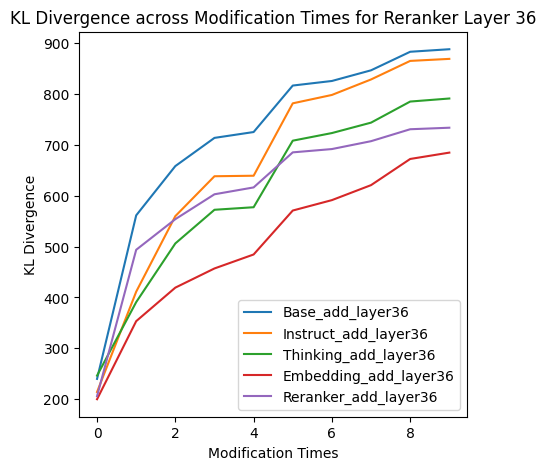

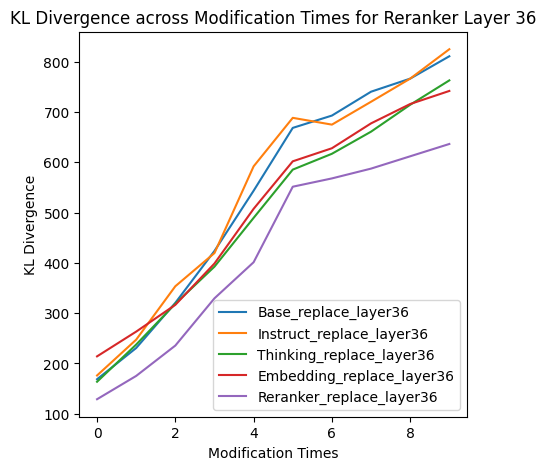

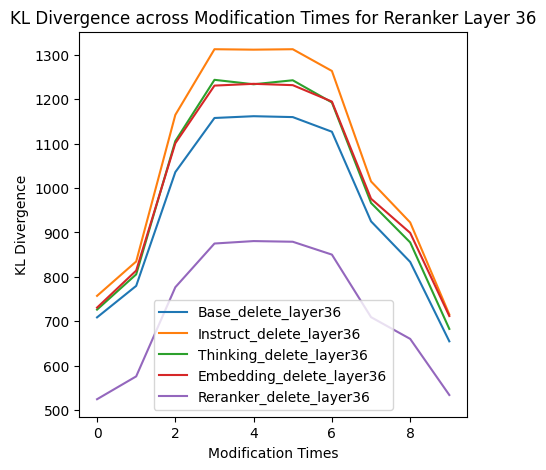

In [22]:
# plot the different action on the same model and layer
for layer_num in range(len(model_names[names]['all_embeddings'])):
    if layer_num not in [36]:
        continue
    
    for action in mod_action:
        plt.figure(figsize=(5, 5))
        for names in model_names:
            kl_y = []
            times_x = []
            # use the selected 
            for m_times in range(mod_times):
                key = f'{names}_{action}_{m_times}'
                kl_y.append(noise_result[key]['l2_list'][layer_num])
                times_x.append(m_times)
            plt.plot(times_x, kl_y, label=f'{names}_{action}_layer{layer_num}')
        plt.title(f"KL Divergence across Modification Times for {names} Layer {layer_num}")
        plt.xlabel("Modification Times")
        plt.ylabel("KL Divergence")
        plt.legend()
        plt.show()